# 图像增广
:label:`sec_image_augmentation`

在 :numref:`sec_alexnet`中，我们提到过大型数据集是成功应用深度神经网络的先决条件。
图像增广在对训练图像进行一系列的随机变化之后，生成相似但不同的训练样本，从而扩大了训练集的规模。
此外，应用图像增广的原因是，随机改变训练样本可以减少模型对某些属性的依赖，从而提高模型的泛化能力。
例如，我们可以以不同的方式裁剪图像，使感兴趣的对象出现在不同的位置，减少模型对于对象出现位置的依赖。
我们还可以调整亮度、颜色等因素来降低模型对颜色的敏感度。
可以说，图像增广技术对于AlexNet的成功是必不可少的。在本节中，我们将讨论这项广泛应用于计算机视觉的技术。


In [1]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

## 常用的图像增广方法

我们对常用图像增广方法的探索中，我们将使用下面这个尺寸为$400\times 500$的图像作为示例。


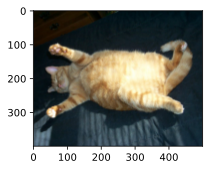

In [2]:
d2l.set_figsize()
img = d2l.Image.open('../img/cat1.jpg')
d2l.plt.imshow(img);

大多数图像增广方法都具有一定的随机性。为了便于观察图像增广的效果，我们下面定义辅助函数`apply`。
此函数在输入图像`img`上多次运行图像增广方法`aug`并显示所有结果。


In [3]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    d2l.show_images(Y, num_rows, num_cols, scale=scale)

### 翻转和裁剪

[**左右翻转图像**]通常不会改变对象的类别。这是最早和最广泛使用的图像增广方法之一。
接下来，我们使用`transforms`模块来创建`RandomFlipLeftRight`实例，这样就各有50%的几率使图像向左或向右翻转。


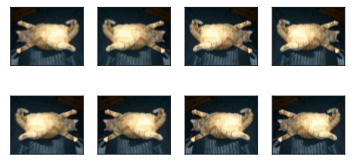

In [4]:
apply(img, torchvision.transforms.RandomHorizontalFlip())

[**上下翻转图像**]不如左右图像翻转那样常用。但是，至少对于这个示例图像，上下翻转不会妨碍识别。接下来，我们创建一个`RandomFlipTopBottom`实例，使图像各有50%的几率向上或向下翻转。


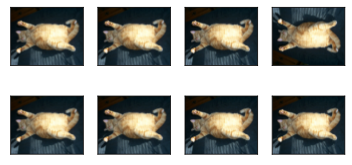

In [5]:
apply(img, torchvision.transforms.RandomVerticalFlip())

在我们使用的示例图像中，猫位于图像的中间，但并非所有图像都是这样。
在 :numref:`sec_pooling`中，我们解释了汇聚层可以降低卷积层对目标位置的敏感性。
另外，我们可以通过对图像进行随机裁剪，使物体以不同的比例出现在图像的不同位置。
这也可以降低模型对目标位置的敏感性。

在下面的代码中，我们[**随机裁剪**]一个面积为原始面积10%到100%的区域，该区域的宽高比从0.5到2之间随机取值。
然后，区域的宽度和高度都被缩放到200像素。
在本节中（除非另有说明），$a$和$b$之间的随机数指的是在区间$[a, b]$中通过均匀采样获得的连续值。


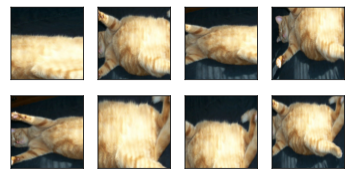

In [6]:
shape_aug = torchvision.transforms.RandomResizedCrop(
    (200, 200), scale=(0.1, 1), ratio=(0.5, 2))
apply(img, shape_aug)

### 改变颜色

另一种增广方法是改变颜色。
我们可以改变图像颜色的四个方面：亮度、对比度、饱和度和色调。
在下面的示例中，我们[**随机更改图像的亮度**]，随机值为原始图像的50%（$1-0.5$）到150%（$1+0.5$）之间。


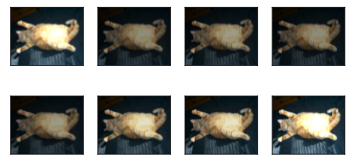

In [7]:
apply(img, torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0, saturation=0, hue=0))

同样，我们可以[**随机更改图像的色调**]。


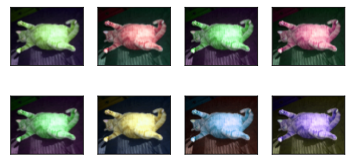

In [8]:
apply(img, torchvision.transforms.ColorJitter(
    brightness=0, contrast=0, saturation=0, hue=0.5))

我们还可以创建一个`RandomColorJitter`实例，并设置如何同时[**随机更改图像的亮度（`brightness`）、对比度（`contrast`）、饱和度（`saturation`）和色调（`hue`）**]。


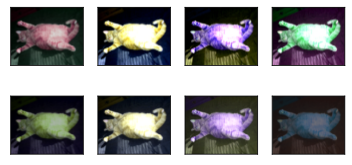

In [9]:
color_aug = torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
apply(img, color_aug)

### [**结合多种图像增广方法**]

在实践中，我们将结合多种图像增广方法。比如，我们可以通过使用一个`Compose`实例来综合上面定义的不同的图像增广方法，并将它们应用到每个图像。


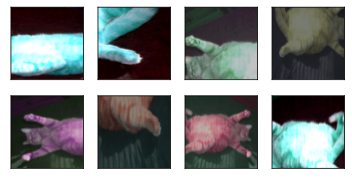

In [10]:
augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(), color_aug, shape_aug])
apply(img, augs)

## [**使用图像增广进行训练**]

让我们使用图像增广来训练模型。
这里，我们使用CIFAR-10数据集，而不是我们之前使用的Fashion-MNIST数据集。
这是因为Fashion-MNIST数据集中对象的位置和大小已被规范化，而CIFAR-10数据集中对象的颜色和大小差异更明显。
CIFAR-10数据集中的前32个训练图像如下所示。


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../data/cifar-10-python.tar.gz to ../data


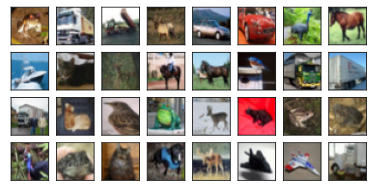

In [11]:
all_images = torchvision.datasets.CIFAR10(train=True, root="../data",
                                          download=True)
d2l.show_images([all_images[i][0] for i in range(32)], 4, 8, scale=0.8);

为了在预测过程中得到确切的结果，我们通常对训练样本只进行图像增广，且在预测过程中不使用随机操作的图像增广。
在这里，我们[**只使用最简单的随机左右翻转**]。
此外，我们使用`ToTensor`实例将一批图像转换为深度学习框架所要求的格式，即形状为（批量大小，通道数，高度，宽度）的32位浮点数，取值范围为0到1。


In [12]:
train_augs = torchvision.transforms.Compose([
     torchvision.transforms.RandomHorizontalFlip(),
     torchvision.transforms.ToTensor()])

test_augs = torchvision.transforms.Compose([
     torchvision.transforms.ToTensor()])

接下来，我们[**定义一个辅助函数，以便于读取图像和应用图像增广**]。PyTorch数据集提供的`transform`函数应用图像增广来转化图像。有关`DataLoader`的详细介绍，请参阅 :numref:`sec_fashion_mnist`。


In [13]:
def load_cifar10(is_train, augs, batch_size):
    dataset = torchvision.datasets.CIFAR10(root="../data", train=is_train,
                                           transform=augs, download=True)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                    shuffle=is_train, num_workers=d2l.get_dataloader_workers())
    return dataloader

### 多GPU训练

我们在CIFAR-10数据集上训练 :numref:`sec_resnet`中的ResNet-18模型。
回想一下 :numref:`sec_multi_gpu_concise`中对多GPU训练的介绍。
接下来，我们[**定义一个函数，使用多GPU对模型进行训练和评估**]。


In [14]:
#@save
def train_batch_ch13(net, X, y, loss, trainer, devices):
    """用多GPU进行小批量训练"""
    if isinstance(X, list):
        # 微调BERT中所需（稍后讨论）
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(pred, y)
    return train_loss_sum, train_acc_sum

In [15]:
#@save
def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
               devices=d2l.try_all_gpus()):
    """用多GPU进行模型训练"""
    timer, num_batches = d2l.Timer(), len(train_iter)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                            legend=['train loss', 'train acc', 'test acc'])
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        # 4个维度：储存训练损失，训练准确度，实例数，特点数
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch_ch13(
                net, features, labels, loss, trainer, devices)
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[3],
                              None))
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {metric[0] / metric[2]:.3f}, train acc '
          f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
          f'{str(devices)}')

现在，我们可以[**定义`train_with_data_aug`函数，使用图像增广来训练模型**]。该函数获取所有的GPU，并使用Adam作为训练的优化算法，将图像增广应用于训练集，最后调用刚刚定义的用于训练和评估模型的`train_ch13`函数。


In [16]:
batch_size, devices, net = 256, d2l.try_all_gpus(), d2l.resnet18(10, 3)

def init_weights(m):
    if type(m) in [nn.Linear, nn.Conv2d]:
        nn.init.xavier_uniform_(m.weight)

net.apply(init_weights)

def train_with_data_aug(train_augs, test_augs, net, lr=0.001):
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    loss = nn.CrossEntropyLoss(reduction="none")
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    train_ch13(net, train_iter, test_iter, loss, trainer, 10, devices)

让我们使用基于随机左右翻转的图像增广来[**训练模型**]。


In [ ]:
train_with_data_aug(train_augs, test_augs, net)

Files already downloaded and verified
Files already downloaded and verified


/home/pcl/dataset/software/miniconda3/envs/mm/lib/python3.7/site-packages/torch/cuda/__init__.py:120: UserWarning: 
    Found GPU%d %s which is of cuda capability %d.%d.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is %d.%d.
    
  warnings.warn(old_gpu_warn.format(d, name, major, minor, min_arch // 10, min_arch % 10))
/home/pcl/dataset/software/miniconda3/envs/mm/lib/python3.7/site-packages/torch/nn/parallel/data_parallel.py:30: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


## 小结

* 图像增广基于现有的训练数据生成随机图像，来提高模型的概化能力。
* 为了在预测过程中得到确切的结果，我们通常对训练样本只进行图像增广，而在预测过程中不使用随机操作的图像增广。
* 深度学习框架提供了许多不同的图像增广方法，这些方法可以被同时应用。

## 练习

1. 在不使用图像增广的情况下训练模型：`train_with_data_aug(no_aug, no_aug)`。比较使用和不使用图像增广的训练结果和测试精度。这个对比实验能支持图像增广可以减轻过拟合的论点吗？为什么？
2. 在基于CIFAR-10数据集的模型训练中结合多种不同的图像增广方法。它能提高测试准确性吗？
3. 参阅深度学习框架的在线文档。它还提供了哪些其他的图像增广方法？


[Discussions](https://discuss.d2l.ai/t/2829)
